In [150]:
import importlib
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
import lib.utils_RSA as rsa

importlib.reload(rsa)


<module 'lib.utils_RSA' from '/home/alban/SAYCam_Vs_EGO4D/lib/utils_RSA.py'>

The 3 images shown - are their resulting activations?


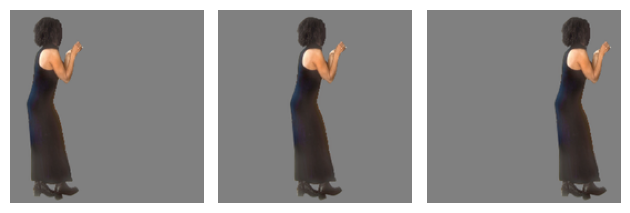

['stimulus7_left.tif', 'stimulus7.tif', 'stimulus7_right.tif']

In [151]:
# First do some analysis on the translation test - see if my understanding of representations are right

path2activations = '/data/alban/activations/saycam_hmIT_Translationtest'
#path2dataset = 'testsets/hmIT_Translationtest'
path2dataset = 'testsets/hmIT_Translationtest'

listimages = os.listdir(path2dataset)
fig, subs = plt.subplots(1,3)
for i, img in enumerate(listimages):
    img = cv2.imread(join(path2dataset, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    subs[i].imshow(img)
    subs[i].axis('off')
print('The 3 images shown - are their resulting activations?')
fig.tight_layout()
plt.show()

listimages

In [152]:
cls_token = list()
patch_token = list()
for i, im in enumerate(listimages):
    cls_token.append(np.load(join(path2activations, f'cls_token_{im[:-4]}.npy')))
    patch_token.append(np.load(join(path2activations, f'patch_token_{im[:-4]}.npy')))
cls_token = np.array(cls_token)
patch_token = np.array(patch_token).reshape(3,-1)
patch_token.shape

(3, 7680000)

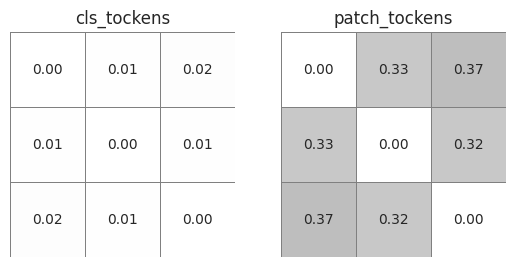

In [153]:
### Correlations
corr_cls = np.corrcoef(cls_token)
corr_patch = np.corrcoef(patch_token)

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(1- corr_cls,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1- corr_patch,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

subs[0].set_title('cls_tockens')
subs[1].set_title('patch_tockens')

subs[0].axis('off')
subs[1].axis('off')

plt.show()



In [154]:
## Dot product
dot_cls = rsa.similarity_dotproduct(cls_token)
dot_patch = rsa.similarity_dotproduct(patch_token)


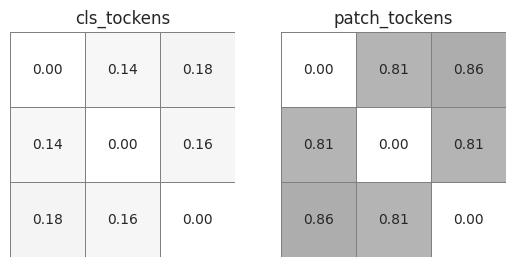

In [155]:

l2_cls = rsa.similarity_L2norm(cls_token)
l2_patch = rsa.similarity_L2norm(patch_token)

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(l2_cls,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=2)               # Set maximum value for color scale

sns.heatmap(l2_patch,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=2)               # Set maximum value for color scale

subs[0].set_title('cls_tockens')
subs[1].set_title('patch_tockens')

subs[0].axis('off')
subs[1].axis('off')

plt.show()


As we did expect, we have low dissimilarity scores when using the cls_tokens as representations, and mid when suing the patch tokens. This suggests that the cls tokens are largely agnostic of spatial properties, and thus more appropriate to compare how semantic information is being represented.

Let's do the same with the actual 92 images.

In [156]:
# Get image paths and the dataset's metadata
from natsort import natsorted
import pandas as pd

df = pd.read_excel('testsets/metadata_hmIT/mapping.xlsx')
print(df)


       class1      class2  class3     image  informed_exclude
0     animate       human    body  0001.jpg                 0
1     animate       human    body  0002.jpg                 0
2     animate       human    body  0003.jpg                 0
3     animate       human    body  0004.jpg                 0
4     animate       human    body  0005.jpg                 0
..        ...         ...     ...       ...               ...
87  inanimate  artificial  object  0088.jpg                 0
88  inanimate  artificial  object  0089.jpg                 0
89  inanimate  artificial  object  0090.jpg                 1
90  inanimate  artificial  object  0091.jpg                 0
91  inanimate  artificial  object  0092.jpg                 0

[92 rows x 5 columns]


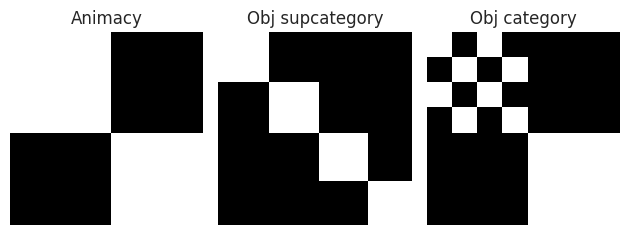

In [157]:
# Create similarity matrices for animacy
animate = df['class1'] == 'animate'
inanimate = df['class1'] == 'inanimate'
corr_animacy = np.corrcoef(np.stack([animate,inanimate], axis =1))

# Create similarity matrices for all object supcategories
human = df['class2'] == 'human'
animal = df['class2'] == 'animal'
natural = df['class2'] == 'natural'
artificial = df['class2'] == 'artificial'
corr_supobj = np.corrcoef(np.stack([human,animal, natural, artificial], axis =1))

#create similarity matrice for object categories
labels = df['class3'].unique()
vecs = list()
for label in labels:
    vecs.append(df['class3'] == label)
corr_obj = np.corrcoef(np.stack(vecs, axis =1))

fig, subs = plt.subplots(1,3)
sns.heatmap(1-corr_animacy,
            annot=False,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1-corr_supobj,
            annot=False,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,

            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1-corr_obj,
            annot=False,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[2],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale


subs[0].set_title('Animacy')
subs[1].set_title('Obj supcategory')
subs[2].set_title('Obj category')

subs[0].axis('off')
subs[1].axis('off')
subs[2].axis('off')
fig.tight_layout()
plt.show()
fig.savefig('figures/RDM_classes.png', dpi=300, bbox_inches='tight')


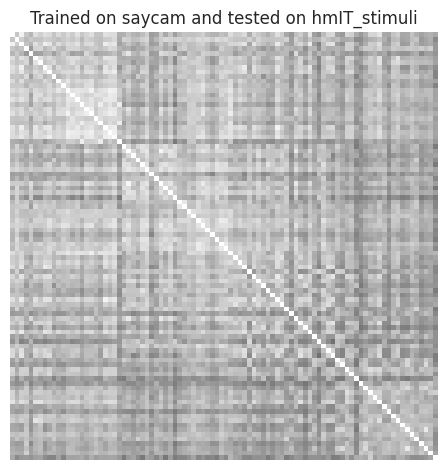

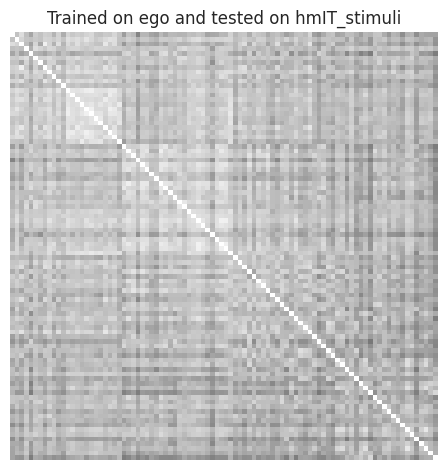

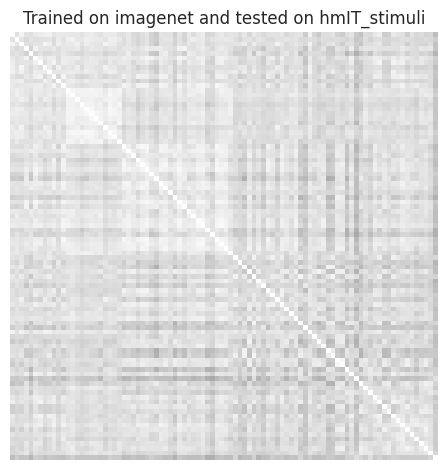

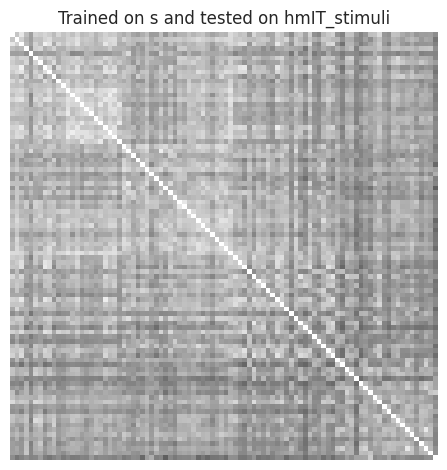

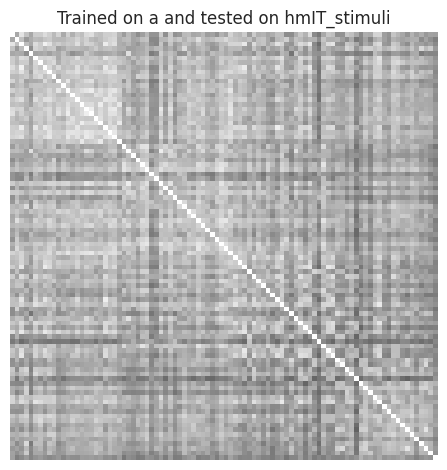

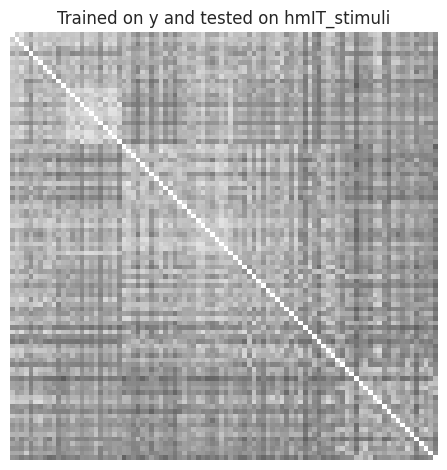

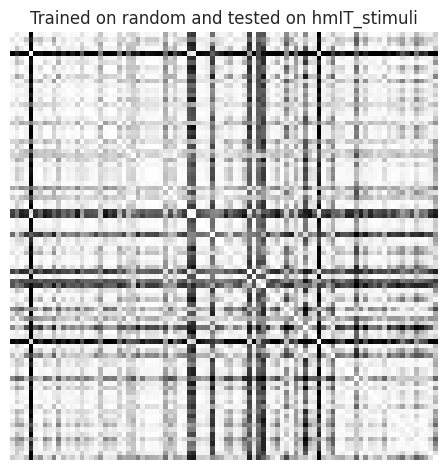

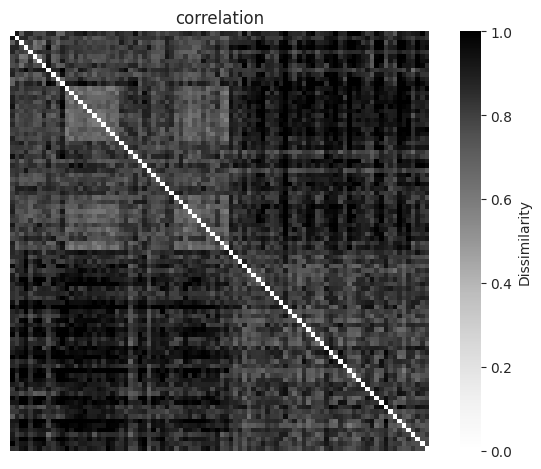

In [173]:
importlib.reload(rsa)
dataset = 'hmIT_stimuli' # alternatively 100_faces or hm_IT_stimuli
path2dataset = f'testsets/{dataset}'

models = ['saycam', 'ego', 'imagenet', 's', 'a', 'y', 'random']

listimages = os.listdir(path2dataset)
listimages = natsorted(listimages) # for hm_IT dataset or
#print(listimages)

RDMs = {}
for i, model in enumerate(models):
    RDMs[model] = rsa.compute_RDMs(model, dataset, listimages)

### Load RDMs from humans
RDMs['humans'] = np.loadtxt('testsets/metadata_hmIT/RDM_hIT_fig1.txt')
RDMs['monkeys'] = np.loadtxt('testsets/metadata_hmIT/RDM_mIT_fig1.txt')
rsa.display_RDM(RDM_humans, 'humans')

In [175]:
SIMs = rsa.corrs_layers(RDMs, models)

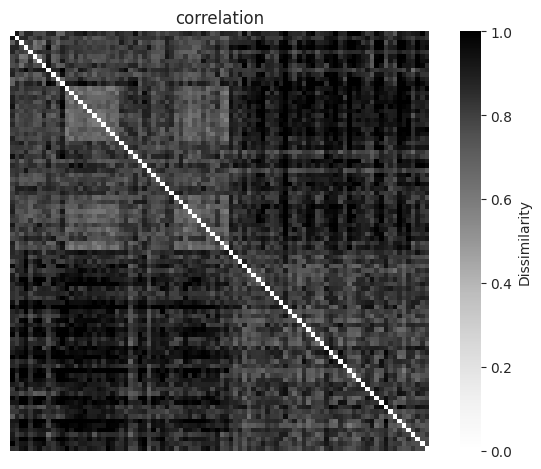

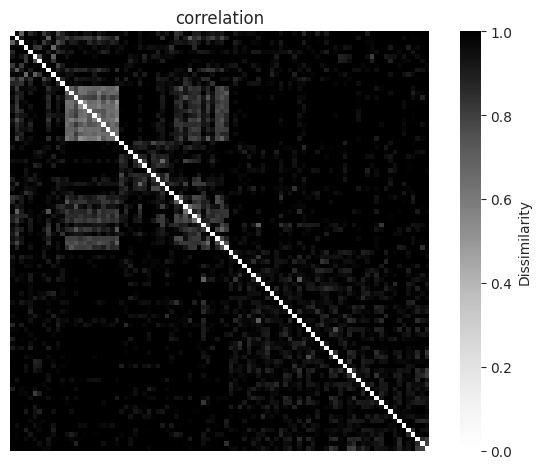

In [176]:

### for comparison, load the RDMs from humans and monkeys
RDM_humans = np.loadtxt('testsets/metadata_hmIT/RDM_hIT_fig1.txt')
RDM_monkeys = np.loadtxt('testsets/metadata_hmIT/RDM_mIT_fig1.txt')

rsa.display_RDM(RDM_humans, 'humans')
rsa.display_RDM(RDM_monkeys, 'monkeys')

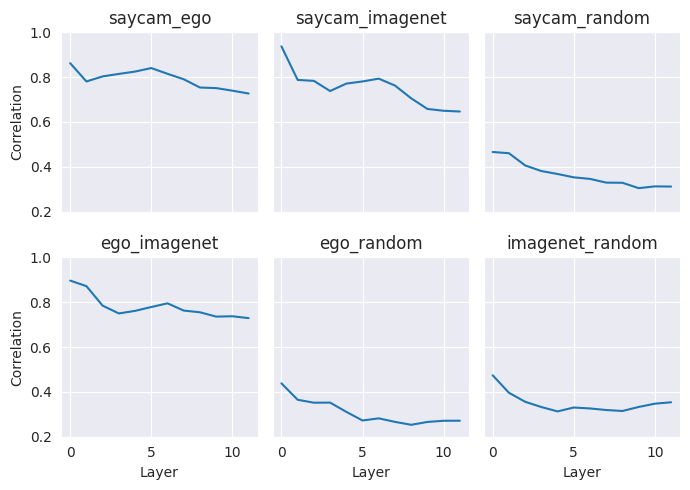

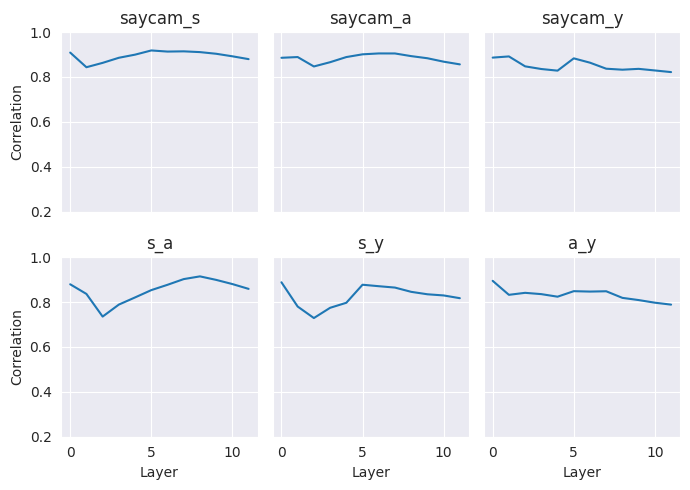

In [215]:

rsa.plot_similarities(SIMs, ['saycam', 'ego', 'imagenet', 'random'])
rsa.plot_similarities(SIMs, ['saycam', 's', 'a', 'y'])

In [22]:
sim_humans_s = rsa.Compute_sim_RDMs(RDM_humans, 1-corr_s)
sim_humans_a = rsa.Compute_sim_RDMs(RDM_humans, 1-corr_a)
sim_humans_y = rsa.Compute_sim_RDMs(RDM_humans, 1-corr_y)

print(f'The correlation between humans and s is {sim_humans_s}.')
print(f'The correlation between humans and a is {sim_humans_a}.')
print(f'The correlation between humans and y is {sim_humans_y}.')

The correlation between s and a is 0.8587661085706404.
The correlation between s and y is 0.8172561261432746.
The correlation between a and y is 0.7885826912005173.
The correlation between say and s is 0.8794045348999774.
The correlation between say and a is 0.856077609442466.
The correlation between say and y is 0.8216615822197079.
The correlation between humans and s is 0.28566532404990785.
The correlation between humans and a is 0.21555697924134187.
The correlation between humans and y is 0.27317868087784614.


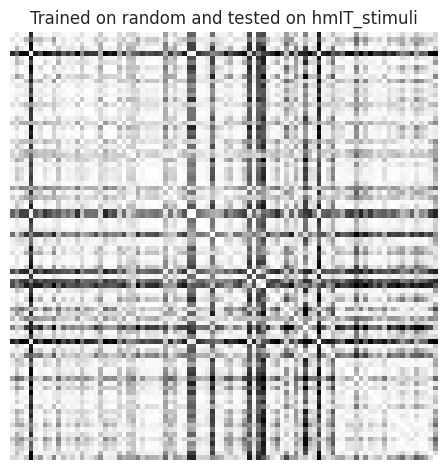

The correlation between say and s is 0.3291068994323753.
The correlation between ego and a is 0.29033804450023204.
The correlation between imagenet and y is 0.3799250934152273.


In [23]:
### Random model
### Do the analysis for models trained individually on s, a and y.
corr_random, l2_s = rsa.compute_RDMs('random', dataset, listimages)

sim_say_rand = rsa.Compute_sim_RDMs(corr_saycam, corr_random)
sim_ego_rand = rsa.Compute_sim_RDMs(corr_ego, corr_random)
sim_imagenet_rand = rsa.Compute_sim_RDMs(corr_imagenet, corr_random)

print(f'The correlation between say and s is {sim_say_rand}.')
print(f'The correlation between ego and a is {sim_ego_rand}.')
print(f'The correlation between imagenet and y is {sim_imagenet_rand}.')

Running t-SNE on dissimilarity matrix...


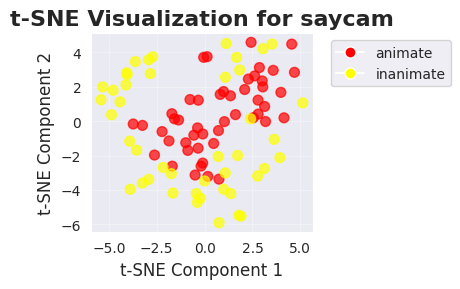

Silhouette Score: 0.102
Number of unique labels: 2

Label distribution:
  animate: 48 images
  inanimate: 44 images
Running t-SNE on dissimilarity matrix...


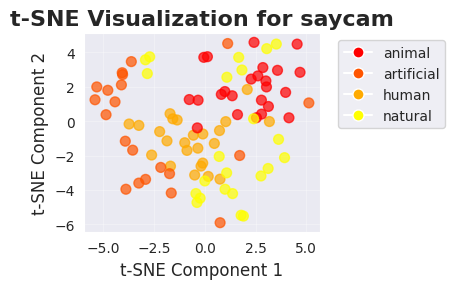

Silhouette Score: 0.083
Number of unique labels: 4

Label distribution:
  animal: 24 images
  artificial: 21 images
  human: 24 images
  natural: 23 images
Running t-SNE on dissimilarity matrix...


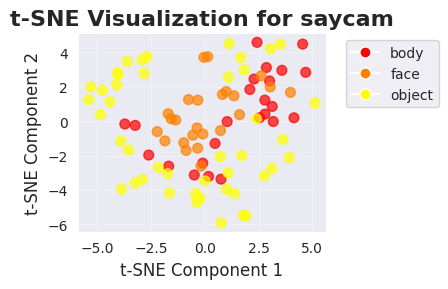

Silhouette Score: -0.029
Number of unique labels: 3

Label distribution:
  body: 24 images
  face: 24 images
  object: 44 images
Running t-SNE on dissimilarity matrix...


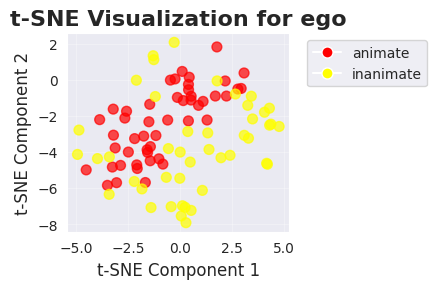

Silhouette Score: 0.123
Number of unique labels: 2

Label distribution:
  animate: 48 images
  inanimate: 44 images
Running t-SNE on dissimilarity matrix...


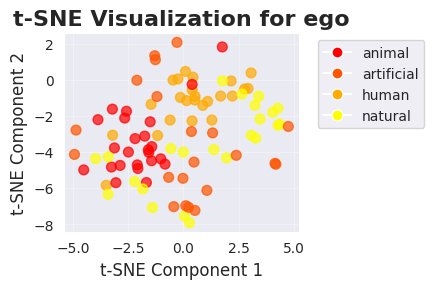

Silhouette Score: 0.069
Number of unique labels: 4

Label distribution:
  animal: 24 images
  artificial: 21 images
  human: 24 images
  natural: 23 images
Running t-SNE on dissimilarity matrix...


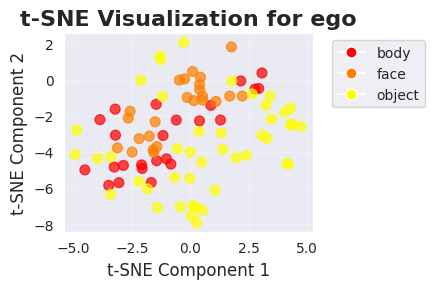

Silhouette Score: -0.001
Number of unique labels: 3

Label distribution:
  body: 24 images
  face: 24 images
  object: 44 images


In [24]:
### Work towards t-sne visualization

# Main execution

labels1 = df['class1'] # Animacy
labels2 = df['class2'] # Animacy
labels3 = df['class3'] # Animacy

# For demonstration, run with synthetic data
title="t-SNE Visualization for saycam"
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['saycam'], labels1, title)
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['saycam'], labels2, title)
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['saycam'], labels3, title)

title="t-SNE Visualization for ego"
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['ego'], labels1, title)
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['ego'], labels2, title)
tsne_results, labels = rsa.complete_tsne_pipeline(RDMs['ego'], labels3, title)

# 2. Save results
results_df = pd.DataFrame({
    'tsne_x': tsne_results[:, 0],
    'tsne_y': tsne_results[:, 1],
    'label': labels,
    'image_id': range(len(labels))
})
